# Parte 1 - Background do Projeto

- Objetivo do Modelo: Prever se o cliente assinará um depósito a prazo 
- Fonte de dados: UCI Learning Repository - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#
- Arquivo utilizado: bank-full.csv
- Número de instâncias (linhas): 45211
- Número de futures (variáveis): 17


Questões:

1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?
2. Fazendo uma relação entre número de contatos e sucesso da campanha quais
são os pontos relevantes a serem observados?
3. Baseando-se nos resultados de adesão desta campanha qual o número médio e
o máximo de ligações que você indica para otimizar a adesão?
4. O resultado da campanha anterior tem relevância na campanha atual?
5. Qual o fator determinante para que o banco exija um seguro de crédito?
6. Quais são as características mais proeminentes de um cliente que possua
empréstimo imobiliário?


In [62]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

linkname = 'bank-full.csv'
dataset1 = pd.read_csv(linkname, sep = ';')


In [63]:
# Load data file
df = pd.read_csv('bank-full.csv', sep=';')

In [64]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [65]:
df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [66]:
# Biblioteca pandas profiling para análise e visualização das análises estatísticas
import pandas_profiling as pp
pp.ProfileReport(df)

Number of variables,17
Number of observations,45211
Total Missing (%),0.0%
Total size in memory,5.9 MiB
Average record size in memory,136.0 B
Numeric,7
Categorical,10
Boolean,0
Date,0
Text (Unique),0
Rejected,0


# Parte 2 - Data Cleaning

Não há valor ausente neste conjunto de dados. No entanto, existem valores como "desconhecido", "outros", que são impotentes como valores ausentes. Portanto, esses valores ambíguos são removidos do conjunto de dados.

In [67]:
# Etapa 1: Excluir as linhas em que a coluna 'poutcome' contém 'other'
condition = dataset1.poutcome == 'other'
dataset2 = dataset1.drop(dataset1[condition].index,axis = 0, inplace=False)

In [68]:
# Etapa 2: Substituir 'desconhecido' no trabalho e na educação por 'outro'
dataset2[['job', 'education']] = dataset2[['job', 'education']].replace(['unknown'], 'other')

Para capturar a tendência geral no conjunto de dados, os valores discrepantes da coluna "balance" são descartados. Os valores extremos são definidos como os valores que estão a mais de três desvios-padrão da média.

In [69]:
from scipy.stats import zscore

dataset2[['balance']].mean()
dataset2[['balance']].mean()

dataset2['balance_outliers'] = dataset2['balance']
dataset2['balance_outliers'] = zscore(dataset2['balance_outliers'])

condition1 = (dataset2['balance_outliers']>3) | (dataset2['balance_outliers']<-3)
dataset3 = dataset2.drop(dataset2[condition].index, axis = 0, inplace = False)              

In [70]:
dataset4 = dataset3.drop('balance_outliers', axis=1)

In [71]:
dataset4['balance'].max()

102127

Algumas alterações foram feitas no nome da coluna, unidades e tipos de dados para facilitar a análise.

In [72]:
# Etapa 1: alterando o nome da coluna: 'y' para 'response'
dataset4.rename(index=str, columns={'y':'response'}, inplace = True)

def convert(dataset4, new_column, old_column):
    dataset4[new_column] = dataset4[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return dataset4[new_column].value_counts()

convert(dataset4, "response_binary", "response")



0    38389
1     4982
Name: response_binary, dtype: int64

In [73]:
#Etapa 2: Dropar a coluna "contato"
dataset5 = dataset4.drop('contact', axis=1)

In [74]:
# Etapa 3: Alterando a unidade de 'duração' de segundos para minutos
dataset5['duration'] = dataset5['duration'].apply(lambda n:n/60).round(2)

In [75]:
# Etapa 4: Alterando 'mês' de palavras para números para facilitar a análise
lst = [dataset5]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

Filtragem

In [76]:
# Etapa 1: descarte linhas com 'duração' <5s
condition2 = (dataset5['duration']<5/60)
dataset6 = dataset5.drop(dataset5[condition2].index, axis = 0, inplace = False)

In [77]:
# Step 2: Redução dos valores dos clientes com a educação 'outra'
condition3 = (dataset6['education'] == 'other')
dataset7 = dataset6.drop(dataset6[condition3].index, axis = 0, inplace = False)

# Part 3 - Análise Exploratória dos Dados


Para obter uma melhor compreensão do conjunto de dados, foram traçadas a distribuição das principais variáveis ​​e os relacionamentos entre elas.

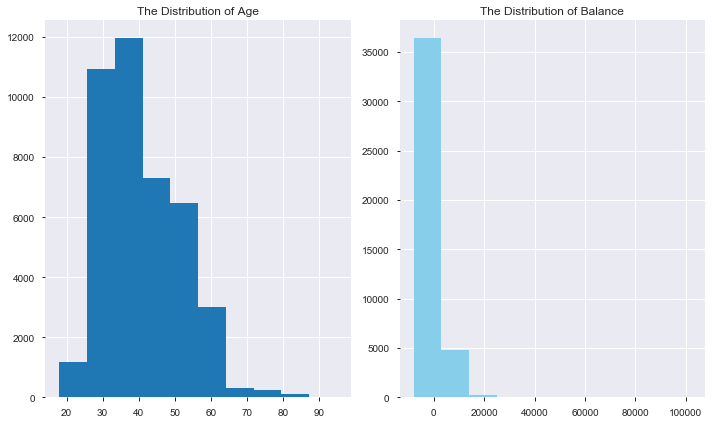

In [78]:
# Visualização da distribuição de 'idade' e 'equilíbrio'
%matplotlib inline

dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1) 
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(dataset7['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(dataset7['balance'], color = 'skyblue')
ra2.set_title('The Distribution of Balance')

plt.tight_layout() 
plt.show()

In [79]:
dataset5['balance'].std()

3030.956348308994

A distribuição da idade: em suas campanhas de telemarketing, os clientes chamados pelo banco têm uma extensa faixa etária, de 18 a 95 anos. No entanto, a maioria dos clientes chamados tem entre 30 e 40 anos (33 a 48 anos se enquadram nos percentis 25 a 75). A distribuição da idade do cliente é bastante normal, com um pequeno desvio padrão.

A distribuição do saldo: Após a retirada de valores discrepantes, o saldo ainda é massivo. A distribuição do saldo apresenta um grande desvio padrão em relação à média, sugerindo grandes variabilidades nos níveis de saldo dos clientes.

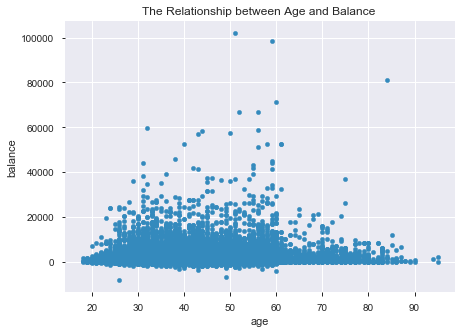

In [80]:
# 3.2 Analisando a relação entre 'idade' e 'saldo'
scatter_age_balance = dataset7.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

Com base nesse gráfico de dispersão, não há uma relação clara entre a idade e o saldo do cliente.

No entanto, com mais de 60 anos, os clientes tendem a ter um saldo significativamente menor, principalmente abaixo de 5.000 euros. Isso se deve ao fato de a maioria das pessoas se aposentar após os 60 anos e não ter mais uma fonte de renda confiável.

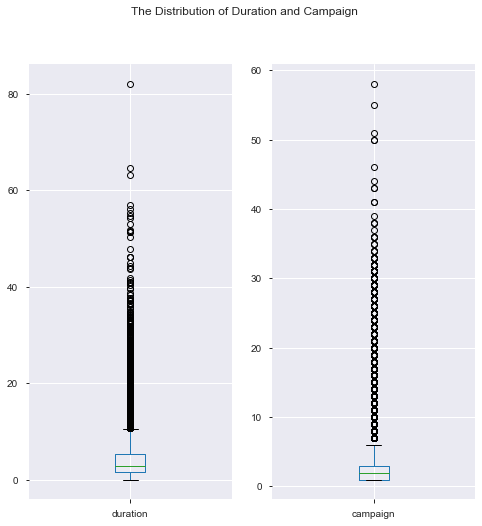

In [81]:
# Visualizando a distribuição entre duração e campanha
dist_dur_cam = dataset7[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()


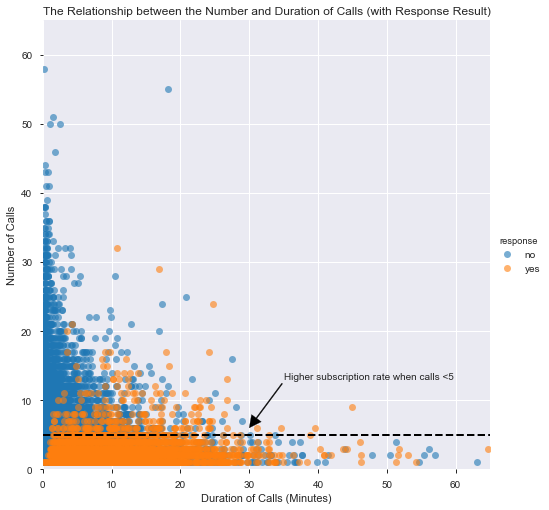

In [82]:
# Análise do relacionamento entre 'duração' e 'campanha': com resultado da 'response'

import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = dataset7,
                     hue = 'response',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

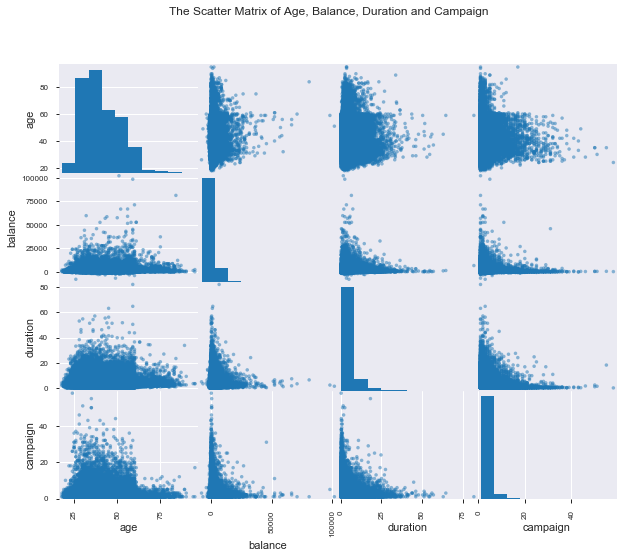

In [83]:
# Matriz de dispersão e correlação

from pandas.plotting import scatter_matrix
matrix = scatter_matrix(dataset7[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

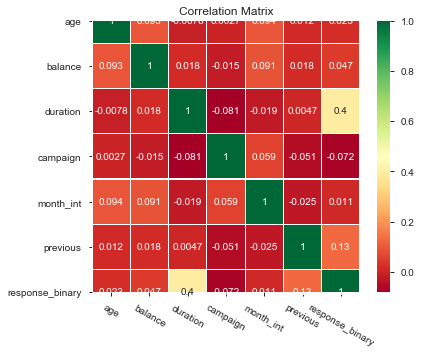

In [84]:
corr_data = dataset7[['age','balance','duration','campaign','month_int','previous','response_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

A matriz de dispersão não revela nenhuma relação clara entre idade, saldo, duração e campanha.

Para investigar mais sobre correlação, uma matriz de correlação foi plotada com todas as variáveis qualitativas. Claramente, "resultado da campanha" tem uma forte correlação com "duração", uma correlação moderada com "contatos anteriores" e correlações moderadas entre "equilíbrio", "mês de contato" e "número de campanha". Suas influências no resultado da campanha serão investigadas mais adiante na parte de aprendizado de máquina.

# Part 4 - Visualização dos Dados


In [85]:
# Visualização da taxa de inscrição e contato por idade

In [86]:
lst = [dataset7]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

In [87]:
count_age_response_pct = pd.crosstab(dataset7['response'],dataset7['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

In [88]:
age = pd.DataFrame(dataset7['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

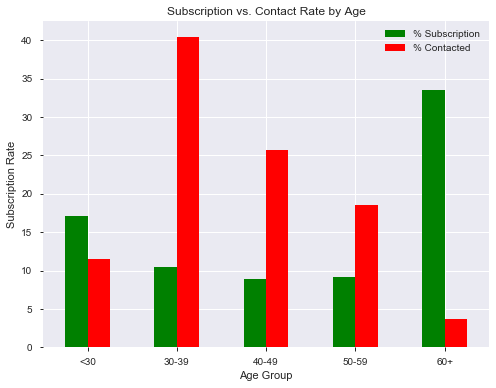

In [89]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

In [90]:
# Visualizando a taxa de assinatura por nível de saldo
lst = [dataset7]
for column in lst:
    column.loc[column["balance"] <= 0, 'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000)]

In [91]:
count_balance_response_pct = pd.crosstab(dataset7['response'],dataset7['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

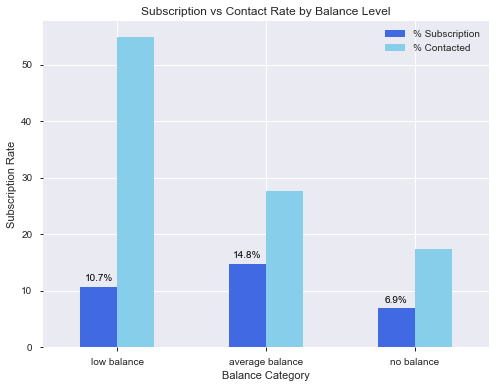

In [132]:
plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('royalblue','skyblue'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

Insights: segmentar clientes com saldo médio ou alto

Para identificar a tendência mais facilmente, os clientes são classificados em quatro grupos com base em seus níveis de equilíbrio:

Sem saldo: clientes com saldo negativo.
Saldo baixo: clientes com saldo entre 0 e 1000 euros
Saldo Médio: clientes com saldo entre 1000 e 5000 euros.
Saldo alto: clientes com saldo superior a 5000 euros.
Sem surpresa, este gráfico de barras indica uma correlação positiva entre os níveis de saldo dos clientes e a taxa de assinatura. Clientes com saldos negativos retornaram apenas uma taxa de assinatura de 6,9%, enquanto clientes com saldos médios ou altos tiveram taxas de assinatura significativamente mais altas, quase 15%.

No entanto, nesta campanha, mais de 50% dos clientes contatados têm apenas um nível de saldo baixo. No futuro, o banco deve mudar seu foco de marketing para clientes de alto saldo para garantir mais depósitos a prazo.

In [133]:
# Visualizando a taxa de assinatura por idade e saldo

age_balance1 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response_binary'].sum())
age_balance2 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['response_binary']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['response_binary','response'],axis =1)

age_balance1 = age_balance1.unstack()

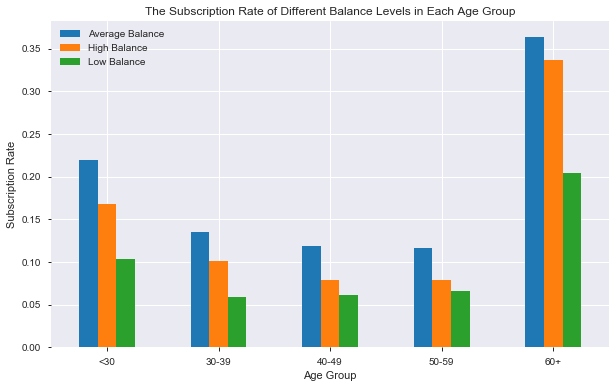

In [134]:
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

In [95]:
# Visualizando a taxa de assinatura por tipo de ocupação

count_job_response_pct = pd.crosstab(dataset7['response'], dataset7['job']).apply(lambda x: x/x.sum()*100)
count_job_response_pct = count_job_response_pct.transpose()

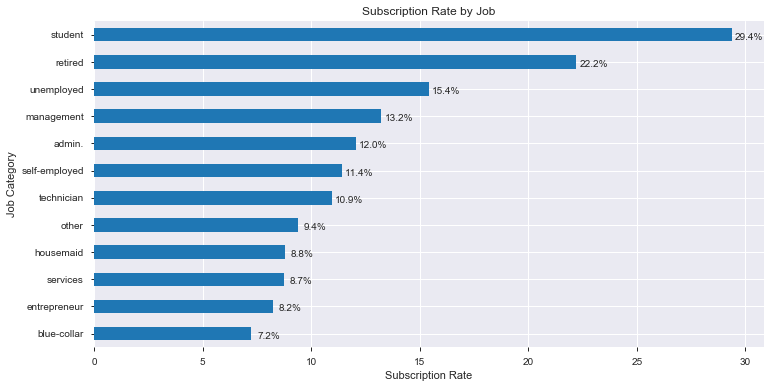

In [96]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Insights: segmentar alunos e clientes aposentados

Conforme observado no gráfico de barras horizontais, estudantes e clientes aposentados representam mais de 40% da assinatura, o que é consistente com a descoberta anterior de taxas de assinatura mais altas entre os mais jovens e mais velhos.

In [97]:
# Analisando a taxa de assinatura e contato por mês

In [98]:
count_month_response_pct = pd.crosstab(dataset7['response'],dataset7['month_int']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()

In [99]:
month = pd.DataFrame(dataset7['month_int'].value_counts())
month['% Contacted'] = month['month_int']*100/month['month_int'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month_int',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)

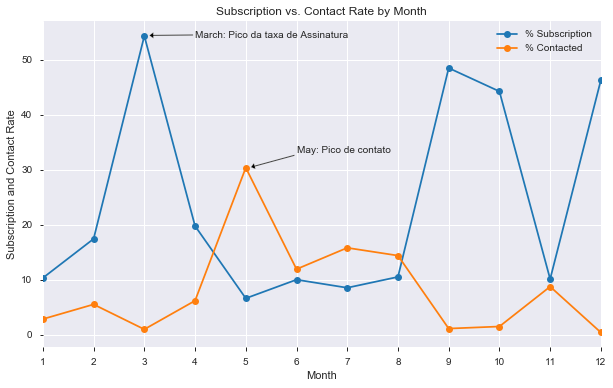

In [100]:
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')


ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: pico de contato
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Pico de contato', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), 
             arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: pico da taxa de assinatura
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Pico da taxa de Assinatura', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), 
             arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()


Insight Estratégico: começar a campanha de telemarketing no outono ou primavera

Além das características do cliente, fatores externos também podem ter um impacto na taxa de assinatura, como estações do ano e horário da ligação. Portanto, o mês de contato também é analisado aqui.

Este gráfico de linhas exibe a taxa de contato do banco em cada mês, bem como a taxa de resposta dos clientes em cada mês. Uma maneira de avaliar a eficácia do plano de marketing do banco é verificar se essas duas linhas têm uma tendência semelhante no mesmo horizonte de tempo.

O banco entrou em contato com a maioria dos clientes entre maio e agosto. A taxa de contato mais alta é de cerca de 30%, o que ocorreu em maio, enquanto a taxa de contato é mais próxima de 0 em março, setembro, outubro e dezembro.
No entanto, a taxa de assinatura mostrou uma tendência diferente. A taxa de assinatura mais alta ocorreu em março, que é superior a 50%, e todas as taxas de assinatura em setembro, outubro e dezembro são superiores a 40%.
Claramente, essas duas linhas se movem em direções diferentes, o que indica fortemente o momento inadequado da campanha de marketing do banco. Para melhorar a campanha de marketing, o banco deve considerar iniciar a campanha de telemarketing no outono e na primavera, quando a taxa de assinatura tende a ser maior.



# 4. O resultado da campanha anterior tem relevância na campanha atual?


Mais dados da campanha de marketing anterior devem ser coletados e analisados e comparados para identificar padrões de aquisição e efeitos de performance na linha temporal.

# Parte 5. Machine Learning: Classificação

O principal objetivo deste projeto é identificar os clientes mais responsivos antes da campanha de marketing, para que o banco possa alcançá-los com eficiência, economizando tempo e recursos de marketing. Para atingir esse objetivo, algoritmos de classificação serão empregados. Ao analisar as estatísticas do cliente, um modelo de classificação será construído para classificar todos os clientes em dois grupos: "sim" para depósitos a prazo e "não" para depósitos a prazo.

In [101]:
# Carregando os dados do dataset limpo

linkname = 'bank_cleaned.csv'
dataset = read_csv(linkname)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [102]:
# Primeiras 5 linhas do dataset limpo
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0



Somente as informações mais relevantes do cliente são consideradas, incluindo cargo, escolaridade, idade, saldo, registro padrão, registro de moradia e empréstimo. Outras informações, como "o número de contatos realizados antes desta campanha", são omitidas porque não estão diretamente relacionadas aos próprios clientes.

In [103]:
dataset.drop(['marital'],axis=1, inplace=True)
dataset1 = dataset.iloc[:, 0:7]


Como os algoritmos de aprendizado de máquina usam apenas valores numéricos, todas as cinco variáveis categóricas (emprego, educação, padrão, moradia e empréstimo) são transformadas em variáveis fictícias.

Variáveis dummy foram usadas em vez de números inteiros contínuos, porque essas variáveis categóricas não são ordinais. Eles simplesmente representam tipos diferentes em vez de níveis, portanto, variáveis fictícias são ideais para distinguir o efeito de diferentes categorias.

In [104]:
dataset2 = pd.get_dummies(dataset1, columns = ['job'])
dataset2 = pd.get_dummies(dataset2, columns = ['education'])
dataset2['housing'] = dataset2['housing'].map({'yes': 1, 'no': 0})
dataset2['default'] = dataset2['default'].map({'yes': 1, 'no': 0})
dataset2['loan'] = dataset2['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset2 = pd.merge(dataset2, dataset_response, left_index = True, right_index = True)

## Seleção de Variáveis

Os valores das 20 primeiras colunas, que contêm estatísticas do cliente, são selecionados como variáveis independentes, enquanto o valor da última coluna, 'resultado da campanha', é definido como a nossa variável alvo (y).

In [105]:
array = dataset2.values

# Features: first 20 columns
X = array[:,0:-1]

# Target variable: 'response_binary'
Y = array[:,-1]

Train test split

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [107]:
# 20% of the data will be used for testing
test_size= 0.20
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Comparação de algoritmos de classificação

Quatro algoritmos de classificação diferentes (Regressão Logística, Classificador K-Neighbours, Classificador de Árvore de Decisão e NB Gaussiano) são executados no conjunto de dados e o de melhor desempenho será usado para construir o modelo de classificação.

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [109]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [110]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10, random_state=seed)    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.885284 (0.005933)
KNN: 0.874938 (0.004055)
CART: 0.833466 (0.006898)
NB: 0.823855 (0.005429)


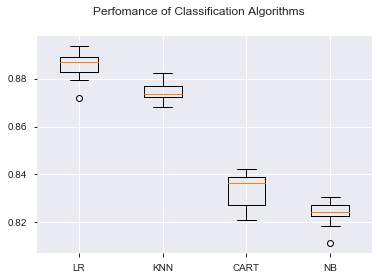

In [111]:
fig = plt.figure()
fig.suptitle('Perfomance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results_c)
ax.set_xticklabels(names_c)
plt.show()

A regressão logística é o modelo com melhor desempenho.

Entre todos os algoritmos, a regressão logística alcançou uma precisão de cerca de 88%, sugerindo um alto nível de força desse modelo para classificar a resposta do cliente, considerando todos os recursos definidos.

In [112]:
# Teste o modelo LR no conjunto de testes

LR = LogisticRegression()
LR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
# Avaliar modelo LR

predictions = LR.predict(X_test)

In [114]:
# Accuracy Score 
print(accuracy_score(Y_test, predictions))

0.890806708287428


A pontuação de precisão é a porcentagem de previsões corretas de todas as previsões feitas. O algoritmo LR atinge uma precisão de 89,08%, sugerindo alto nível de força desse modelo para classificar a resposta do cliente, considerando todos os recursos definidos pelo cliente.

[[7277    1]
 [ 891    0]]


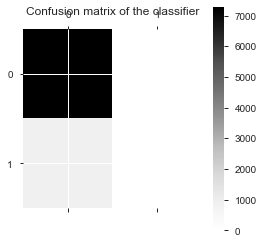

In [115]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import pylab as pl

print(confusion_matrix(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

No entanto, o resultado da pontuação de precisão pode gerar resultados enganosos se o conjunto de dados for desequilibrado, porque o número de observações em diferentes classes varia bastante.

Uma matriz de confusão fornece uma análise detalhada dos tipos de resultado e erro de previsão. Cada célula na matriz representa uma combinação de instâncias da resposta prevista e da resposta real. No conjunto de testes, a matriz prova que o algoritmo teve um bom desempenho porque a maioria dos resultados (7277 previsões de Positivo Verdadeiro) se localiza nas células diagonais que representam previsões corretas. 891 testes (falso negativo) previram que o cliente do banco assinaria o depósito a prazo, mas na verdade não o fizeram.

Um problema revelado por essa matriz de confusão é que o conjunto de dados é altamente desequilibrado, com quase todos os clientes realmente recusando a assinatura. Isso infere que o escore de precisão é tendencioso, e mais avaliações devem ser realizadas para determinar a precisão do modelo de regressão logística.

In [116]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7278
           1       0.00      0.00      0.00       891

    accuracy                           0.89      8169
   macro avg       0.45      0.50      0.47      8169
weighted avg       0.79      0.89      0.84      8169



O relatório de classificação mostra as pontuações de precisão, recall, F1 e suporte para o modelo de classificação LR.

O relatório de classificação mostra as pontuações de precisão, recall, F1 e suporte para o modelo de classificação LR.

A precisão de 0 (o cliente disse que não) representa que, para todas as instâncias previstas como sem assinatura, a porcentagem de clientes que realmente disseram não é de 89%.
Lembre-se é a capacidade de um classificador para encontrar todas as instâncias positivas. A rechamada de 0 indica que, para todos os clientes que realmente disseram não, o modelo prevê 100% corretamente que eles recusariam a oferta.

# Modelos de Regressão


A análise de regressão é realizada para complementar o resultado da classificação e ajudar o banco a prever melhor o resultado da campanha com base nas estatísticas do cliente.

Como a duração de uma ligação telefônica está positivamente correlacionada com o resultado da campanha, ela pode servir como outro indicador da possibilidade de assinatura. Nesta parte, algoritmos de regressão serão usados para estimar a duração de uma ligação telefônica, ajudando o banco a prever melhor a taxa de assinatura.

In [117]:
# Preparaçao dos dados para os modelos de regressão

dataset4 = dataset2.drop(['response_binary'],axis = 1)
dataset4['duration'] = dataset['duration']

# Seleção de Variáveis
Os valores das 19 primeiras colunas, que contêm estatísticas do cliente, são selecionados como recursos, enquanto o valor da última coluna, 'duration', é definido como destino.

In [118]:
array = dataset4.values
X = array[:,0:20]
Y = array[:,20]

Train Test Split

In [119]:
test_size= 0.20
seed = 10
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Comparação algoritmos de regressão

Seis algoritmos de regressão diferentes (Regressão Linear, Lasso, Ridge, ElasticNet, KNN e Árvore de Decisão) são executados no conjunto de dados e o de melhor desempenho será usado para construir o modelo de estimativa.

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [121]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

In [122]:
results_e2 = []
names_e2 = []

for name, model in models:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state=seed)
    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2.append(cv_results)
    names_e2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -18.667426 (1.243464)
LASSO: -18.701201 (1.256921)
RIDGE: -18.667404 (1.243472)
EN: -18.700962 (1.256775)
KNN: -22.237990 (1.196449)
CART: -37.732251 (1.759969)


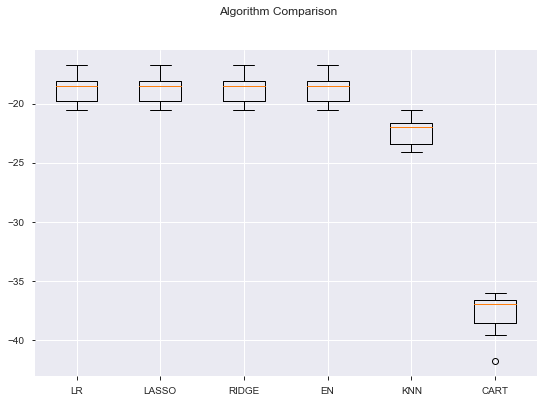

In [123]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

# Padronizando os dados

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('Scaled LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('Scaled RIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('Scaled EN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('Scaled KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))

In [125]:
results_e2_normalized = []
names_e2_normalized = []

for name, model in pipelines:
    # definição da divisão dos dados de validação
    kfold = KFold(n_splits=10, random_state=seed)
    
    # treinando o modelo
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2_normalized.append(cv_results)
    names_e2_normalized.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled LR: -18.668534 (1.245339)
Scaled LASSO: -18.721218 (1.268503)
Scaled RIDGE: -18.667425 (1.243465)
Scaled EN: -18.721218 (1.268503)
Scaled KNN: -22.097842 (1.358002)
Scaled CART: -37.843930 (1.705967)


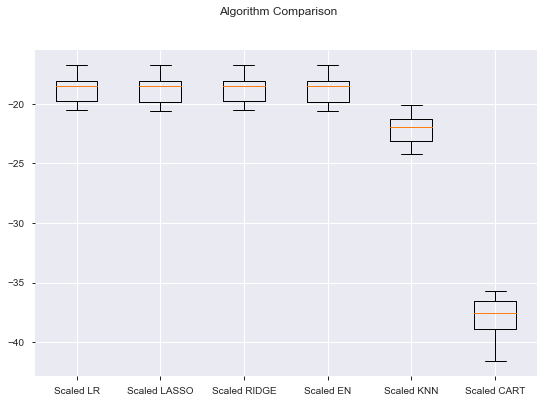

In [126]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2_normalized)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2_normalized)
plt.show()

Após a padronização, Ridge Regression ainda é o modelo com melhor desempenho.

In [127]:
# Teste do modelo RIDGE no conjunto de testes

ridge = Ridge()
ridge.fit(X_train, Y_train)
predicted_y = ridge.predict(X_test)

# Avaliar modelo RIDGE

In [128]:
from sklearn.metrics import mean_squared_error
print('The MSE is', mean_squared_error(Y_test, predicted_y))

The MSE is 17.7797404329447


Um MSE 17.78 indica que Ridge Regression é um modelo sólido na previsão da variável de destino e sugere que o banco possa estimar aproximadamente a duração das chamadas de campanha de cada cliente usando seus perfis de idade, emprego e empréstimos.

# Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

Conclusão:
De acordo com a análise anterior, um perfil de cliente-alvo pode ser estabelecido. Os clientes mais responsivos possuem os seguintes recursos:

Característica 1: idade <30 ou idade> 60
Recurso 2: estudantes ou aposentados
Elemento 3: saldo de mais de 5000 euros
Aplicando algoritmos logísticos e de regressão de crista, modelo de classificação e estimativa foi construído com sucesso. Com esses dois modelos, o banco poderá prever a resposta de um cliente à sua campanha de telemarketing antes de ligar para esse cliente. Dessa forma, o banco pode alocar mais esforços de marketing para os clientes classificados como altamente propensos a aceitar depósitos a prazo e ligar menos para aqueles que provavelmente não farão depósitos a prazo.

Além disso, prever a duração antes de ligar e ajustar o plano de marketing beneficia o banco e seus clientes. Por um lado, aumentará a eficiência da campanha de telemarketing do banco, economizando tempo e esforços. Por outro lado, impede que alguns clientes recebam anúncios indesejáveis, aumentando a satisfação do cliente. Com o auxílio de modelos logísticos e de regressão, o banco pode entrar em um ciclo virtuoso de marketing eficaz, mais investimentos e clientes mais satisfeitos.

# Respostas:

## 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

Estudantes e aposentados com o tipo de empréstimo de longo prazo.O banco pode alocar mais esforços de marketing para os clientes classificados como altamente propensos a aceitar depósitos a prazo e ligar menos para aqueles que provavelmente não farão depósitos a prazo.

## 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

Podemos concluir que o número de chamadas ideal fica entre 8 e no máximo 10 chamadas, após essa faixa oberservamos quedas nas aquisições. No grupo em que os clientes disseram "sim", as durações tendem a ser mais longas.

## 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?


Como podemos ver no gráfico, os clientes "sim" e "não" estão formando dois grupos relativamente separados. Comparado aos clientes “não”, os clientes “sim” foram contatados menos vezes e tiveram uma duração de chamada mais longa. Mais importante, após um volume a partir de 18 chamadas aproximadamente, é mais provável que os clientes rejeitem o depósito a prazo, a menos que a duração seja alta. A maioria dos clientes "sim" foi abordada menos de 10 vezes.

Isso sugere que o banco deve resistir a ligar para um cliente por mais de 10 vezes, o que pode ser perturbador e aumentar a insatisfação.

## 4. O resultado da campanha anterior tem relevância na campanha atual?

A maioria dos clientes com contato "desconhecido" disse "não" para o depósito e também teve um resultado "desconhecido" na campanha anterior. A partir dessa premissa podemos sim inferir também em outros pontos e determinar a relevância na campanha atual.

## 5. Qual o fator determinante para que o banco exija um seguro de crédito?

Possuir algum tipo de empréstimo, pessoal ou imobiliário

## 6. Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

Na sua grande maioria são clientes com cargo de gestão, representando ~76%. Todos eles adquiriam depósitos de longo prazo e possuem idade média de 39 anos.
